In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import os
import re
import pandas as pd
from unidecode import unidecode
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

### Carga de dataset

In [2]:
ruta = r"C:/Users/rhernandez/OneDrive - Generando Soluciones Anlalíticas S.A/Documents/New folder/Proyecto_Fase_2/datasets"
archivos = [os.path.join(ruta, f) for f in os.listdir(ruta) if f.endswith(".xlsx")]

dfs = {}

for archivo in archivos:
    base = os.path.basename(archivo)
    match = re.search(r"\d{4}", base)
    if match:
        anio = match.group()
        df = pd.read_excel(archivo)
        dfs[f"df_{anio}"] = df

for year in range(2020, 2024 + 1):
    name = f"df_{year}"
    if name in dfs:
        df = dfs[name]

        df.columns = [unidecode(c).lower() for c in df.columns]

        df.columns = [re.sub(r"gran_grupos|gran_grupos", "gran_grupos", c) for c in df.columns]
        df.columns = [re.sub(r"subg_primarios|subg_principales", "subg_principales", c) for c in df.columns]
        df.columns = [re.sub(r"g_primarios", "g_primarios", c) for c in df.columns]

        df = df.drop(columns=["edad_quinquenales", "ocupacionhabitual", "filter_$"], errors="ignore")

        if "area_geo_inf" in df.columns:
            df["area_geo_inf"] = df["area_geo_inf"].astype(str)

        dfs[name] = df

df_final = pd.concat([dfs[f"df_{y}"] for y in range(2020, 2024 + 1)], ignore_index=True)
df_final = df_final.drop(columns=["num_corre"], errors="ignore")
df_final["area_geo_inf"] = pd.to_numeric(df_final["area_geo_inf"], errors="coerce")
df_final.head()

,depto_boleta,muni_boleta,mes_boleta,ano_boleta,falta_inf,sexo_inf,edad_inf,grupo_etnico_inf,est_conyugal_inf,nacimiento_inf,...,niv_escolaridad_inf,est_ebriedad_inf,area_geo_inf,depto_nacimiento_inf,nacionalidad_inf,g_edad_80ymas,g_edad_60ymas,subg_principales,gran_grupos,g_primarios
0,1,102,1,2020,3,1,29,2,1,101,...,4,1,2,1,1,4,4,971,12,NaN
1,1,102,1,2020,3,1,19,2,1,101,...,3,1,2,1,1,2,2,94,9,NaN
2,1,102,1,2020,4,1,19,2,1,101,...,3,1,2,1,1,2,2,94,9,NaN
3,1,102,1,2020,3,1,22,2,1,101,...,3,1,2,1,1,3,3,31,3,NaN
4,1,102,1,2020,4,1,22,2,1,101,...,3,1,2,1,1,3,3,31,3,NaN


In [77]:
#df_final_bk = df_final.copy()
df_final = df_final_bk.copy()

In [76]:
df_final['ano_boleta'].unique()

array([2020, 2023, 2022, 2024, 2021], dtype=int64)

### Red 1: Prediccion del año de la falta

In [78]:
df_final = df_final.sample(frac = 1, random_state=42).reset_index(drop = True)

In [79]:
var_red_1 = ['depto_boleta', 'mes_boleta', 'sexo_inf', 'falta_inf', 'edad_inf',
    'est_conyugal_inf', 'est_ebriedad_inf', 'area_geo_inf',
    'subg_principales', 'gran_grupos', 'g_primarios']

X = df_final[var_red_1]
y = df_final['ano_boleta']

In [60]:
le = LabelEncoder()
y = le.fit_transform(y)

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
model = Sequential()
model.add(Dense(64, input_dim = 11, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

c:\Users\rhernandez\Anaconda3\envs\agentes\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [63]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

In [80]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)         
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight = dict(zip(classes, weights))
print(class_weight)

{0: 0.5374334237765048, 1: 0.9565372920765516, 2: 1.2802681189777965, 3: 1.487311409302649, 4: 1.5614598540145985}


In [73]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop], class_weight= class_weight)

Epoch 1/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2269 - loss: 1.6115 - val_accuracy: 0.1318 - val_loss: 1.6108
Epoch 2/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1895 - loss: 1.6095 - val_accuracy: 0.1286 - val_loss: 1.6082
Epoch 3/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1741 - loss: 1.6095 - val_accuracy: 0.3662 - val_loss: 1.6067
Epoch 4/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2284 - loss: 1.6095 - val_accuracy: 0.1591 - val_loss: 1.6126
Epoch 5/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2128 - loss: 1.6095 - val_accuracy: 0.1318 - val_loss: 1.6156
Epoch 6/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1755 - loss: 1.6095 - val_accuracy: 0.3662 - val_loss: 1.6073


In [74]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3662 - loss: 1.6067
Loss: 1.6066839694976807, Accuracy: 0.3661929666996002


836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


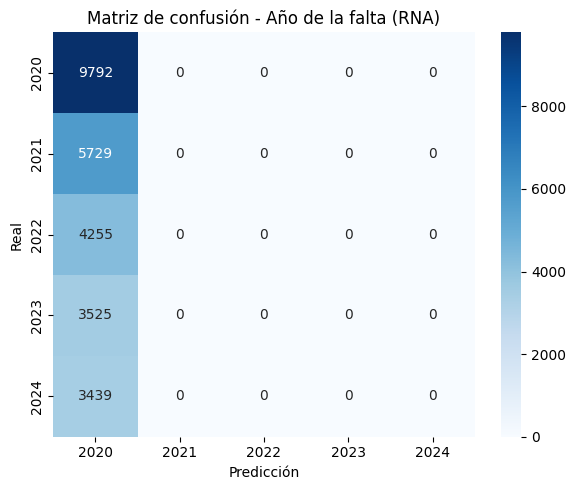

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)   
y_true = y_test                           

cm = confusion_matrix(y_true, y_pred)

labels = le.inverse_transform(np.arange(len(le.classes_)))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - Año de la falta')
plt.tight_layout()
plt.show()

In [ ]:
persona_rn_1_2 = pd.DataFrame({
    "depto_boleta":      [1],      
    "mes_boleta":        [3],      
    "sexo_inf":          [1],      
    "falta_inf":         [3],      
    "edad_inf":          [25],
    "est_conyugal_inf":  [1],      
    "est_ebriedad_inf":  [1],      
    "area_geo_inf":      [1],      
    "subg_principales":  [5223],   
    "gran_grupos":       [5],      
    "g_primarios":       [0]       
})

pred_1 = model.predict(persona_rn_1_2)
pred_1_clase = le.inverse_transform([pred_1.argmax(axis=1)[0]])

print(pred_1_clase)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
[2020]


In [ ]:
persona_rn_1_1 = pd.DataFrame({
    "depto_boleta":      [9],      
    "mes_boleta":        [10],     
    "sexo_inf":          [2],      
    "falta_inf":         [5],      
    "edad_inf":          [40],
    "est_conyugal_inf":  [2],     
    "est_ebriedad_inf":  [2],      
    "area_geo_inf":      [2],      
    "subg_principales":  [6111],   
    "gran_grupos":       [6],      
    "g_primarios":       [1]       
})

pred_1 = model.predict(persona_rn_1_1)
pred_1_clase = le.inverse_transform([pred_1.argmax(axis=1)[0]])

print(pred_1_clase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[2020]


### Red 2: Tipo de falta

In [106]:
df_final = df_final.sample(frac = 1, random_state=42).reset_index(drop = True)

In [107]:
var_red_2 = ['depto_boleta' , 'muni_boleta' , 'mes_boleta' , 'ano_boleta' , 'sexo_inf' , 'edad_inf' , 
               'grupo_etnico_inf' , 'est_conyugal_inf' , 'nacimiento_inf' , 'cond_alfabetismo_inf' , 'niv_escolaridad_inf' 
             , 'est_ebriedad_inf' , 'area_geo_inf' , 'depto_nacimiento_inf' , 'subg_principales' , 'gran_grupos' , 'g_primarios']

X = df_final[var_red_2]
y = df_final['falta_inf']

In [108]:
le = LabelEncoder()
y = le.fit_transform(y)

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
model = Sequential()
model.add(Dense(64, input_dim = 17, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

c:\Users\rhernandez\Anaconda3\envs\agentes\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [111]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

In [112]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3863 - loss: 1.6223 - val_accuracy: 0.3887 - val_loss: 1.3901
Epoch 2/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3866 - loss: 1.3950 - val_accuracy: 0.3887 - val_loss: 1.3902
Epoch 3/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3866 - loss: 1.3950 - val_accuracy: 0.3887 - val_loss: 1.3903
Epoch 4/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3866 - loss: 1.3950 - val_accuracy: 0.3887 - val_loss: 1.3901


836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


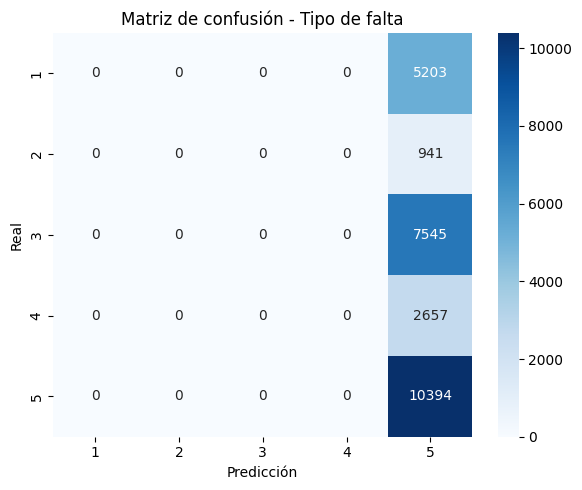

In [113]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)   
y_true = y_test                           

cm = confusion_matrix(y_true, y_pred)

labels = le.inverse_transform(np.arange(len(le.classes_)))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - Tipo de falta')
plt.tight_layout()
plt.show()